In [ ]:
%load_ext autoreload
%autoreload 2
from hig_data.coco import COCOStuffGraphPrecomputedDataset
import torch
path = '/home/rfsm2/rds/hpc-work/datasets/coco/coco_train2017_hig.h5'
coco_graph = COCOStuffGraphPrecomputedDataset(path)
data = coco_graph[10]
# data

In [18]:
import json

path = '/home/rfsm2/rds/hpc-work/datasets/vg/raw_vg/attributes.json'
with open(path, 'r') as f:
    data = json.load(f) 

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
from hig_data.visualisation import logging_generate_sample_vis, visualise_het_graph_on_image_batch, plot_array_images,convert_latents_to_pixels
from training.encoders import StabilityVAEEncoder
vae = StabilityVAEEncoder()
data = coco_graph[0].image
print(coco_graph[0].mask_path)
data2 = coco_graph[1].image
print(coco_graph[1].mask_path)
decoded_img = data if vae is None else convert_latents_to_pixels(data, vae)
decoded_img2 = data2 if vae is None else convert_latents_to_pixels(data2, vae)


In [ ]:
import numpy as np
plot_array_images(decoded_img.transpose(2,0,1)[np.newaxis,...])
plot_array_images(decoded_img2.transpose(2,0,1)[np.newaxis,...])

In [7]:
from hig_data.coco import CocoStuffGraphDataset

img_path = '/home/rfsm2/rds/hpc-work/datasets/coco/processed_coco/coco_train2017_256-sdxl.zip'
img_path_flipped = '/home/rfsm2/rds/hpc-work/datasets/coco/processed_coco/coco_train2017_256-sdxl-f.zip'
mask_path = '/home/rfsm2/rds/hpc-work/datasets/coco/processed_coco/coco_train2017_masks_256.zip'
label_path = '/home/rfsm2/rds/hpc-work/datasets/coco/processed_coco/coco_train2017_labels.json'
caption_path = '/home/rfsm2/rds/hpc-work/datasets/coco/processed_coco/coco_train2017_caption-clip.zip'
vocab_path = "/home/rfsm2/rds/hpc-work/datasets/coco/processed_coco/class_name_clip_latents.json"
dataset = CocoStuffGraphDataset(img_path,
                                mask_path,
                                labels_path=label_path,
                                captions_path=caption_path,
                                vocab_path=vocab_path,
                                image_path_flipped=img_path_flipped,
                                xflip=True)


Found 118280 complete datapoint in /home/rfsm2/rds/hpc-work/datasets/coco/processed_coco/coco_train2017_256-sdxl.zip


In [10]:
len(dataset)
# dataset._xflip[7000]

236560

In [11]:
data = dataset[0]
data = dataset[236560//2]

In [ ]:
len(dataset)

In [12]:
from hig_data.visualisation import logging_generate_sample_vis, visualise_het_graph_on_image_batch, plot_array_images,convert_latents_to_pixels
from training.encoders import StabilityVAEEncoder
vae = StabilityVAEEncoder()
data = dataset[1].image
data2 = dataset[(236560//2)+1].image


In [ ]:
import numpy as np
np.allclose(data, data2)

In [13]:
import torch
decoded_img = data if vae is None else convert_latents_to_pixels(torch.tensor(data), vae)
decoded_img2 = data2 if vae is None else convert_latents_to_pixels(torch.tensor(data2), vae)

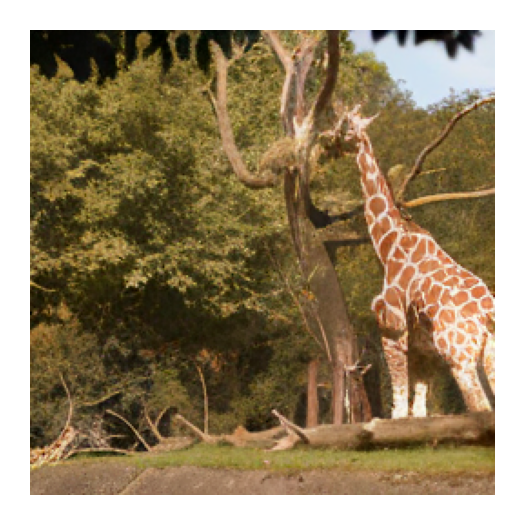

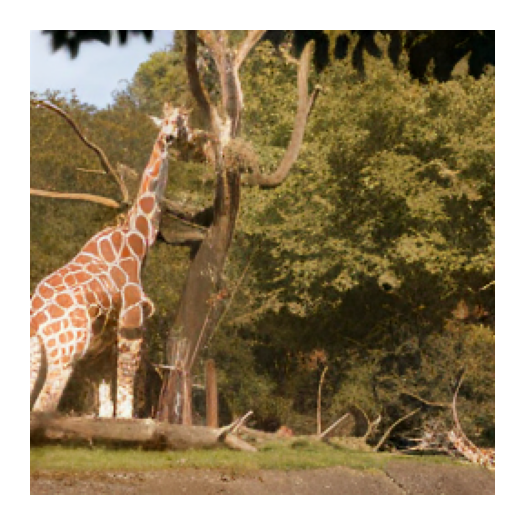

In [14]:
import numpy as np
plot_array_images(decoded_img.transpose(2,0,1)[np.newaxis,...])
plot_array_images(decoded_img2.transpose(2,0,1)[np.newaxis,...])

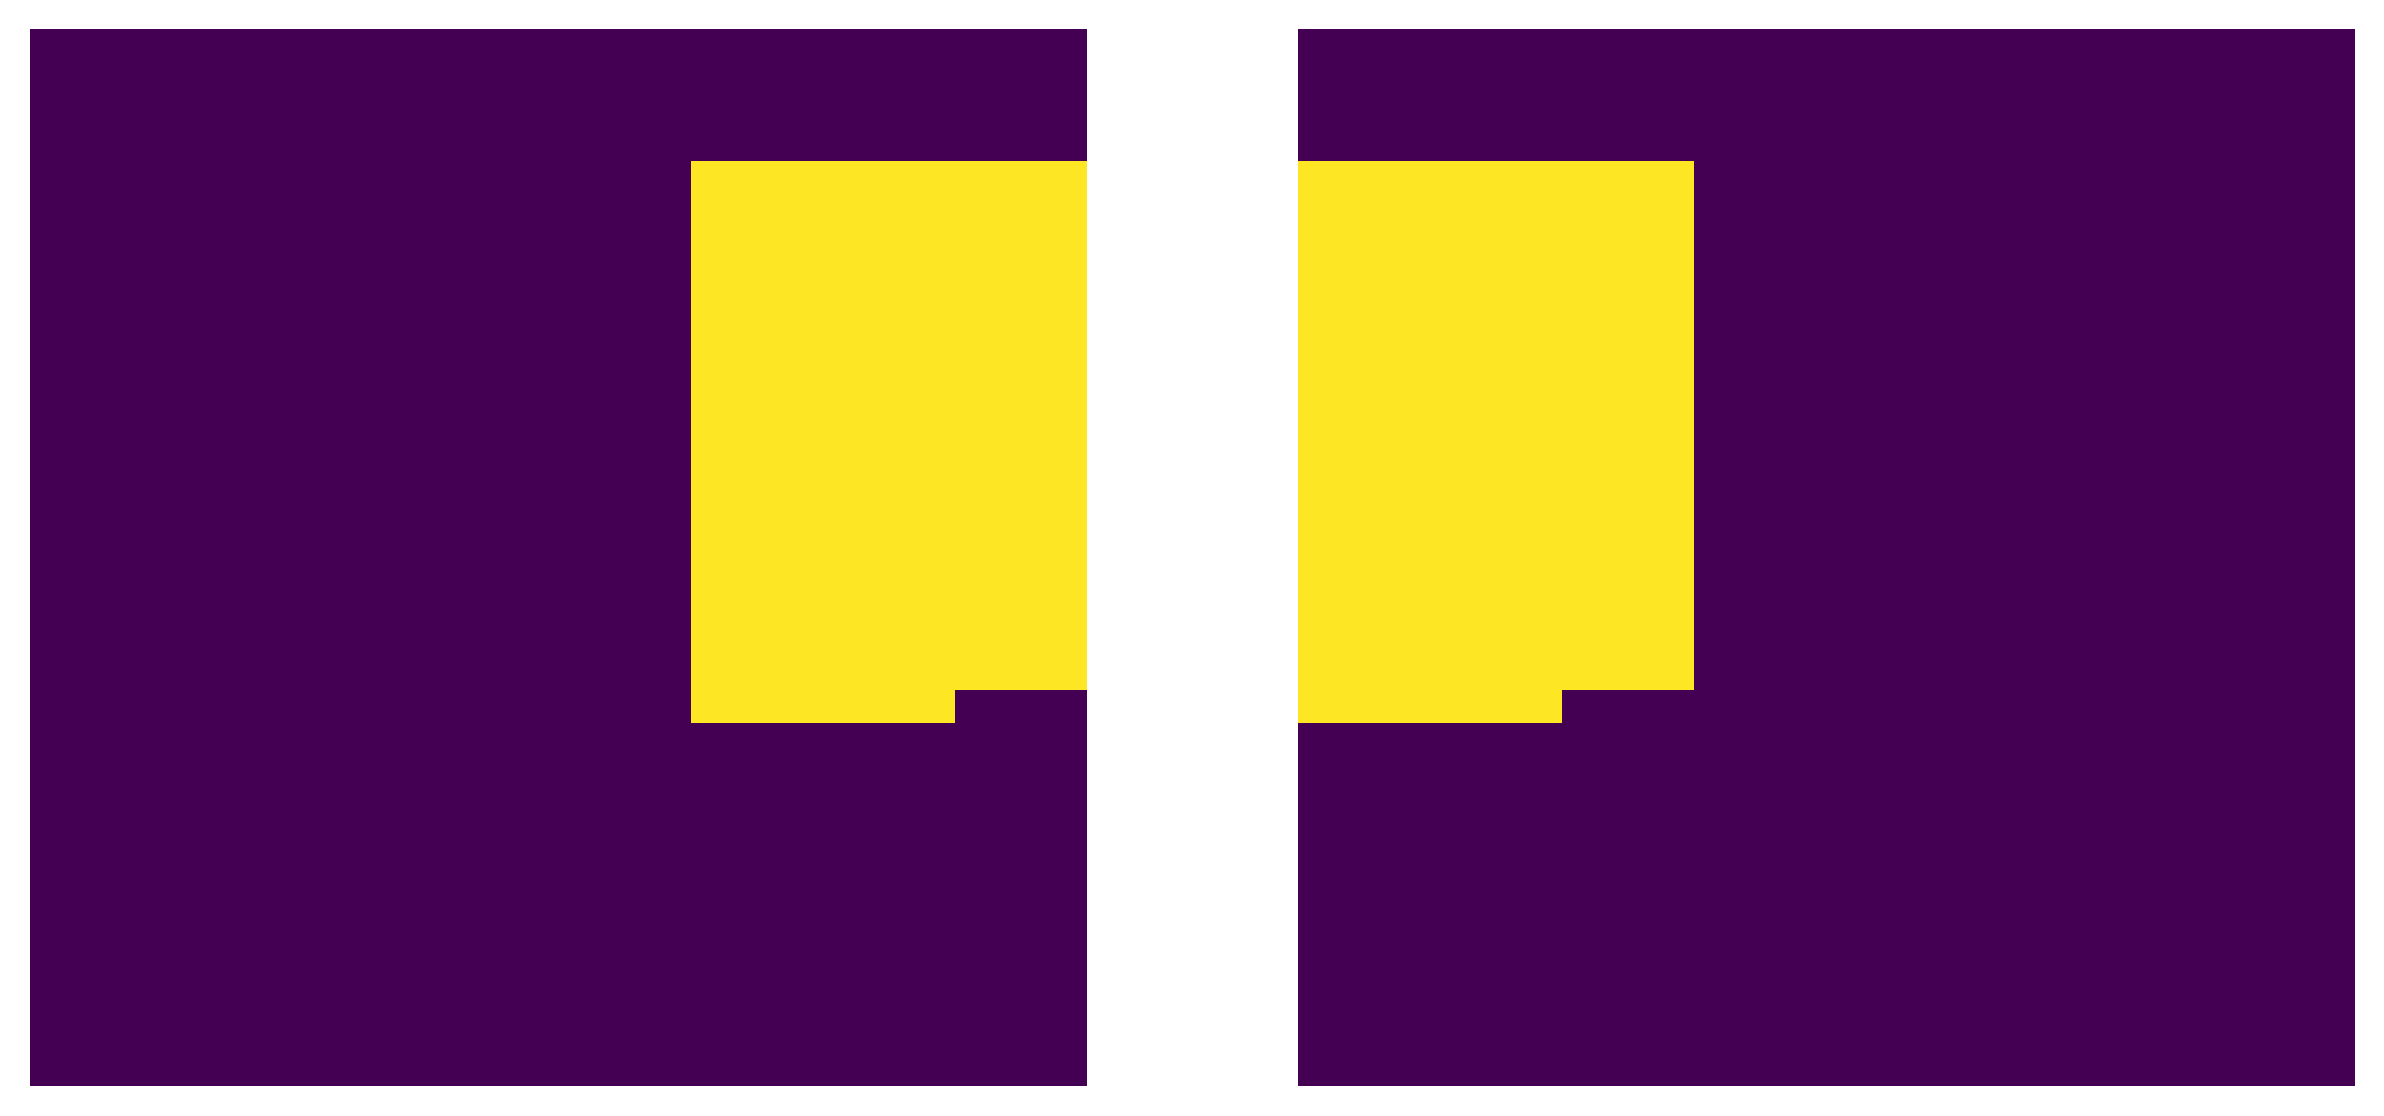

In [17]:
import torch
data = dataset[1]
data2 = dataset[(236560//2)+1]
bb_1 = data['instance_to_image'].edge_index
bb_2 = data2['instance_to_image'].edge_index
from hig_data.coco import linear_to_2d_idx
bb_1, bb_2
img_bb_1 = linear_to_2d_idx(torch.tensor(bb_1[1]))[:,:200]
img_bb_2 = linear_to_2d_idx(torch.tensor(bb_2[1]))[:,:200]

from hig_data.visualisation import plot_array_images
image = torch.zeros((2, 1, 32, 32))
image[0,:,img_bb_1[0], img_bb_1[1]] = 1.
image[1,:,img_bb_2[0], img_bb_2[1]] = 1.

plot_array_images(image)

0.140625 0.140625


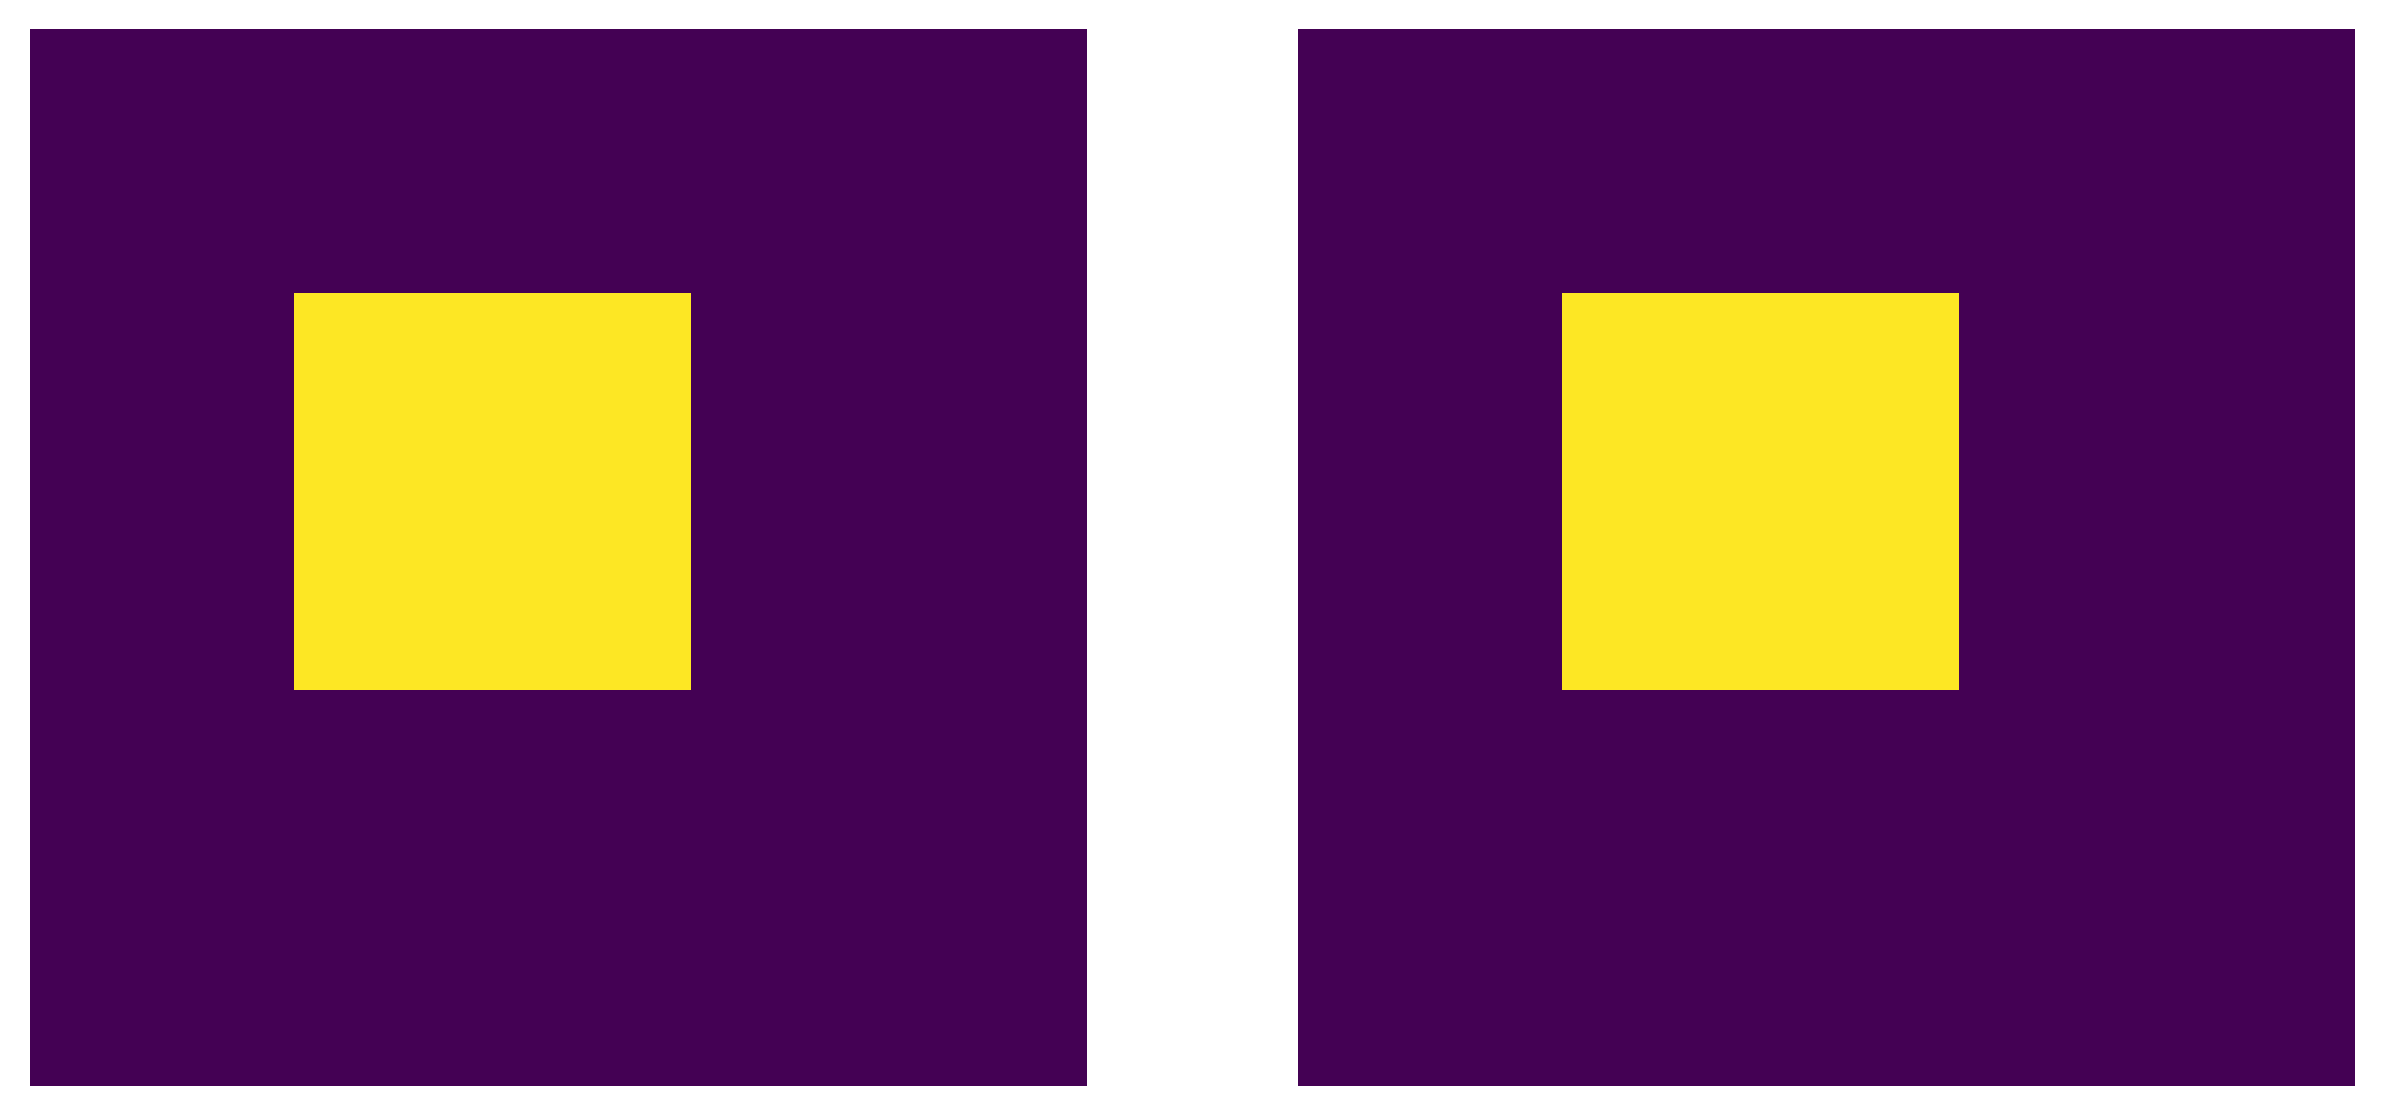

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-18.503841..25.725481].


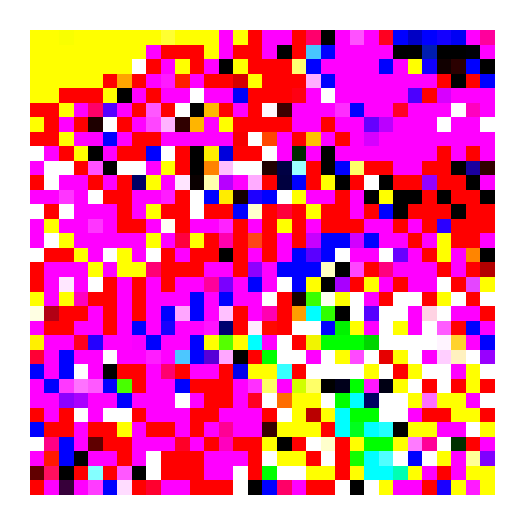

In [15]:
import torch
import numpy as np
from hig_data.visualisation import plot_array_images
image = np.zeros((2,1, 32, 32))
image[:,:,8:20, 8:20]=1.
print(np.mean(image[0]), np.mean(image[1]))
plot_array_images(image)
plot_array_images(dataset[0].image[:, :3,:,:])

In [ ]:
from torch_geometric.loader import DataLoader as GeoDataLoader
dls = GeoDataLoader(dataset, batch_size=32, shuffle=True)
graph_batch = next(iter(dls))
graph_batch


In [4]:
precond.unet.enc['32x32_block0'].hignn

HIGnnInterface(
  (gnn): GraphModule(
    (gnn_layers): ModuleList(
      (0): ModuleDict(
        (image_node): MP_GeoLinear(-1, 192,)
        (class_node): MP_GeoLinear(-1, 192,)
        (instance_node): MP_GeoLinear(-1, 192,)
      )
      (1-2): 2 x ModuleDict(
        (class_node__class_edge__class_node): MP_HIPGnnConv((-1, -1), 192, aggr=MP_Sum_Aggregation())
        (class_node__class_to_image__image_node): MP_HIPGnnConv((-1, -1), 192, aggr=MP_Sum_Aggregation())
        (instance_node__instance_edge__instance_node): MP_HIPGnnConv((-1, -1), 192, aggr=MP_Sum_Aggregation())
        (instance_node__instance_to_image__image_node): MP_HIPGnnConv((-1, -1), 192, aggr=MP_Sum_Aggregation())
      )
    )
  )
)

In [8]:
from training.networks_edm2_hignn import Precond
import torch
precond = Precond(32, 4, gnn_metadata = dataset[0].metadata())
blank_image = torch.zeros((1, 192, 32, 32))
out, new_graph = precond.unet.enc['32x32_block0'].hignn(blank_image, dataset[0].clone())
out.shape

TypeError: linalg_vector_norm(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
from hig_data.visualisation import logging_generate_sample_vis, visualise_het_graph_on_image_batch, plot_array_images
# logging_generate_sample_vis(graph_batch, resize_mask=True)
from training.encoders import StabilityVAEEncoder
vae = StabilityVAEEncoder()
img, decoded = visualise_het_graph_on_image_batch(graph_batch, vae=vae,)
print(img.shape)
plot_array_images(img)


In [ ]:
import torch
from training.networks_edm2_hignn import Precond
precond = Precond(32, 3, label_dim=768, gnn_metadata = data.metadata())

images = torch.randn(1, 3, 32, 32)
rnd_normal = torch.randn([images.shape[0], 1, 1, 1], device=images.device)
sigma = (rnd_normal).exp()

data = coco_graph[1]
out = precond(images, sigma, data, class_labels=data.caption)
out.shape

In [ ]:
images = torch.randn(1, 3, 32, 32)
rnd_normal = torch.randn([images.shape[0], 1, 1, 1], device=images.device)
sigma = (rnd_normal).exp()

data = coco_graph[1]
out = precond(images, sigma, data, class_labels=data.caption)
out.shape

In [ ]:
%load_ext autoreload
%autoreload 2

from hig_data.sg2im_coco import CocoAnnoations

root = '/home/rfsm2/rds/hpc-work/datasets/coco/'
img_dir = root+'val2017'
instances_json = root+'annotations/instances_val2017.json'
stuff_json = root+'annotations/stuff_val2017.json'
captions_json = root+'annotations/captions_val2017.json'
coco_sg = CocoAnnoations(stuff_json=stuff_json, instances_json=instances_json, captions_json=captions_json)

In [ ]:
from training.encoders import CLIPEncoder
clip = CLIPEncoder(batch_size=1)
text_latents = clip.encode_raw_text(text_data, device='cuda')[0].cpu().numpy().tolist()

In [ ]:
len(coco_sg.vocab['object_idx_to_name'])

In [3]:
coco_sg.save_vocab_to_json('./coco_2017_class_names.json')

In [ ]:
coco_sg.save_dataset_to_json('/home/rfsm2/rds/hpc-work/datasets/coco/coco_val2017_labels.json')

In [12]:
import ijson
root = '/home/rfsm2/rds/hpc-work/datasets/coco/'
instances_json = root+'annotations/instances_train2017.json'

# def load_json_stream(file_path, prefix, keys):
#     out = {}
#     with open(file_path, "rb") as f:
#         for item in ijson.items(f, 'item'):
#             out[item[keys[0]]] = []
#             for key in keys:
#                 out[item[keys[0]]].append[item[key]]
#     return out

# out_data = load_json_stream(instances_json, 'images', 'file_name')
import json
with open(instances_json) as file:
    my_dict = json.load(file)

In [2]:
import PIL
import numpy as np
def center_crop_imagenet(image_size: int, arr: np.ndarray):
    """
    Center cropping implementation from ADM.
    https://github.com/openai/guided-diffusion/blob/8fb3ad9197f16bbc40620447b2742e13458d2831/guided_diffusion/image_datasets.py#L126
    """
    pil_image = PIL.Image.fromarray(arr)
    while min(*pil_image.size) >= 2 * image_size:
        new_size = tuple(x // 2 for x in pil_image.size)
        assert len(new_size) == 2
        pil_image = pil_image.resize(new_size, resample=PIL.Image.Resampling.BOX)

    scale = image_size / min(*pil_image.size)
    new_size = tuple(round(x * scale) for x in pil_image.size)
    assert len(new_size) == 2
    pil_image = pil_image.resize(new_size, resample=PIL.Image.Resampling.BICUBIC)

    arr = np.array(pil_image)
    crop_y = (arr.shape[0] - image_size) // 2
    crop_x = (arr.shape[1] - image_size) // 2
    return arr[crop_y: crop_y + image_size, crop_x: crop_x + image_size]
def nearest_crop(image_size: int, arr: np.ndarray):
        """
        Center cropping for semantic masks using NEAREST resampling to preserve label information.
        """
        pil_image = PIL.Image.fromarray(arr)

        # Calculate scale based on the target image size
        scale = image_size / min(*pil_image.size)
        new_size = tuple(round(x * scale) for x in pil_image.size)
        assert len(new_size) == 2

        # Resize the image using NEAREST resampling
        pil_image = pil_image.resize(new_size, resample=PIL.Image.Resampling.NEAREST)

        # Convert back to numpy array and crop the center
        arr = np.array(pil_image)
        crop_y = (arr.shape[0] - image_size) // 2
        crop_x = (arr.shape[1] - image_size) // 2
        return arr[crop_y: crop_y + image_size, crop_x: crop_x + image_size]

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
def visualize_bounding_boxes(image: np.ndarray, mask: np.ndarray, bboxes: np.ndarray, labels: list, bbox_color='red', text_color='white'):
    """
    Visualizes bounding boxes on a numpy array image.
    
    Arguments:
        image: 2D NumPy array representing the image.
        bboxes: Bounding boxes as an Nx4 numpy array where each row is [xmin, ymin, xmax, ymax].
                Coordinates are expected to be in 0-1 normalized format.
        bbox_color: The color for the bounding boxes (default is red).
    """
    fig, ax = plt.subplots(1)
    ax.imshow(image,)
    ax.imshow(mask,alpha=0.5)
    
    # Image dimensions
    img_h, img_w, *_ = image.shape
    
    # Iterate over bounding boxes and draw them with labels
    for bbox, label in zip(bboxes, labels):
        # Denormalize bbox coordinates back to pixel values
        xmin, ymin, xmax, ymax = bbox * np.array([img_w, img_h, img_w, img_h])
        width = xmax - xmin
        height = ymax - ymin
        
        # Create a rectangle patch
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor=bbox_color, facecolor='none')
        ax.add_patch(rect)
        
        # Add label text
        ax.text(xmin, ymin - 5, label, color=text_color, fontsize=8, bbox=dict(facecolor=bbox_color, alpha=0.5, pad=1))

    plt.show()

In [ ]:
import PIL
import numpy as np
m=coco_sg[0]
# print(m)
img_name = m['filename']
# print(m)

img = np.array(PIL.Image.open(root+f'val2017/{img_name}.jpg'))
mask = np.array(PIL.Image.open(root+f'val2017_masks/{img_name}.png'))
img = center_crop_imagenet(256,img)
mask = nearest_crop(256,mask)

img = img.reshape(*img.shape[:2], -1)
mask = mask.reshape(*mask.shape[:2], -1)

# PIL.Image.fromarray(img)
PIL.Image.fromarray(mask[:,:,0])

# # i = 10
# # person = m['obj_bbox'][i]
print(sorted(m['obj_class_name']))
# # print(m['obj_class'])
# # print(person)

ids_present = [idx+1 for idx in np.unique(mask) if idx !=255]
print(sorted([coco_sg.vocab['object_idx_to_name'][i] for i in ids_present]))

print(set.union(set(sorted([coco_sg.vocab['object_idx_to_name'][i] for i in ids_present])), set(sorted(m['obj_class_name']))))

# # Denormalize bbox coordinates back to pixel values
# person_bb = person * np.array([256,]*4)
# person_bb = person_bb.astype(int)
# print(person_bb)
# PIL.Image.fromarray(img[person_bb[1]:person_bb[3],person_bb[0]:person_bb[2], ])
# # print(mask.shape)
# cut_out_mask = mask[person_bb[1]:person_bb[3], person_bb[0]:person_bb[2]]
# print(cut_out_mask.shape)
# PIL.Image.fromarray(mask[person_bb[1]:person_bb[3], person_bb[0]:person_bb[2],0])
# # print(mask[person_bb[1]+60:person_bb[3]-70, person_bb[0]+20:person_bb[2]-20,0])
# print(mask[person_bb[1]:person_bb[3],person_bb[0]:person_bb[2], ])

# visualize_bounding_boxes(cropped, mask, m['obj_bbox'], m['obj_class_name'])
# PIL.Image.fromarray(cropped)

In [ ]:
import json
root = '/home/rfsm2/rds/hpc-work/edm2_datasets/coco/'
instances_json = root+'annotations/instances_val2017.json'
stuff_json = root+'annotations/stuff_val2017.json'
captions_json = root+'annotations/captions_val2017.json'
person_key_points_json = root+'annotations/person_keypoints_val2017.json'

for json_file in [instances_json, stuff_json, captions_json, person_key_points_json]:
    with open(json_file, 'r') as f:
        json_file = json.load(f)
    print(list(json_file.keys()))



In [ ]:
person_key_points_json = root+'annotations/person_keypoints_val2017.json'
with open(person_key_points_json, 'r') as f:
    person_key_points = json.load(f)
list(person_key_points['annotations'][0].keys())
# person_key_points['categories']

In [ ]:
person_key_points['annotations'][0]['keypoints']

In [ ]:
stuff_json['annotations']

In [ ]:
import json
captions_json = root+'annotations/captions_val2017.json'
with open(captions_json, 'r') as f:
    captions_data = json.load(f)

print(list(captions_data.keys()))
captions_data['annotations']

In [ ]:
meta_data

In [1]:
from hig_data.coco import COCOStuffDataset

img_path = '/Users/rupertmenneer/Downloads/coco_val2017_256-sd.zip'
mask_path = '/Users/rupertmenneer/Downloads/coco_val2017_masks_256.zip'
dataset = COCOStuffDataset(img_path, mask_path, 32)


In [ ]:
from hig_data.coco import COCOStuffDataset, CocoStuffGraphDataset
import torch
img_path = '/Users/rupertmenneer/Downloads/coco_val2017_256-sd.zip'
mask_path = '/Users/rupertmenneer/Downloads/coco_val2017_masks_256.zip'
coco_graph = CocoStuffGraphDataset(img_path, mask_path, latent_images=True)
data = coco_graph[4]
data

In [ ]:
print(data.mask)
one_hot = torch.nn.functional.one_hot(data.mask, num_classes=256)
print(one_hot.shape)
torch.argmax(one_hot[:,:,0,0,:])

In [ ]:
torch.argmax(data['class_node'].x, dim=1)

In [ ]:
data['class_node'].label

In [ ]:
from hig_data.coco import COCOStuffGraphPrecomputedDataset
import torch
path = '/Users/rupertmenneer/Downloads/coco_graph_train'
coco_graph = COCOStuffGraphPrecomputedDataset(path)
data = coco_graph[4]
data

In [9]:
from hig_data.coco import CocoStuffGraphDataset
import numpy as np
import os
def create_graph_dataset_and_export(output_dir='/Users/rupertmenneer/Downloads/coco_graph'):

    img_path = '/Users/rupertmenneer/Downloads/coco_val2017_256-sd.zip'
    mask_path = '/Users/rupertmenneer/Downloads/coco_val2017_masks_256.zip'
    coco_graph = CocoStuffGraphDataset(img_path, mask_path, latent_images=True)

    for idx in range(len(coco_graph)):
        image, mask = coco_graph.dataset[idx]
        graph = coco_graph[idx]

        name = coco_graph.dataset._fnames['image'][coco_graph.dataset._raw_idx[idx]]
        raw_id = os.path.splitext(os.path.basename(name))[0].split('-')[-1]

        np.save(os.path.join(output_dir, f'{raw_id}_image.npy'), image)
        np.save(os.path.join(output_dir, f'{raw_id}_mask.npy'), mask)
        np.savez(os.path.join(output_dir, f'{raw_id}_graph'),
                 class_node=graph['class_node'].x,
                 class_pos=graph['class_node'].pos,
                 class_edge=graph['class_node', 'class_edge', 'class_node'].edge_index,
                 class_to_image=graph['class_node', 'class_to_image', 'image_node'].edge_index,
                 )

create_graph_dataset_and_export()


In [ ]:
# from hig_data.coco import COCOStuffDataset, CocoStuffGraphDataset
# import torch
# img_path = '/Users/rupertmenneer/Downloads/coco_val2017_256-sd.zip'
# mask_path = '/Users/rupertmenneer/Downloads/coco_val2017_masks_256.zip'
# coco_graph = CocoStuffGraphDataset(img_path, mask_path, latent_images=True)
# data = coco_graph[4]
# data

In [ ]:
128<<13

In [ ]:
# from hig_data.visualisation import convert_latents_to_pixels
# import PIL
# import numpy as np
# print(data.image.shape)
# img = convert_latents_to_pixels(data.image)

# PIL.Image.fromarray(img)

In [2]:
from torch_geometric.loader import DataLoader as GeoDataLoader
dls = GeoDataLoader(coco_graph, batch_size=32, shuffle=True)
# graph_batch = next(iter(dls))
# graph_batch

# graph_batch['image_node'].pos, graph_batch['class_node'].pos

In [ ]:
graph_batch = next(iter(dls))
graph_batch

In [ ]:
graph_batch['class_node'].label[5]

In [ ]:
for i, graph_batch in enumerate(dls):
    print(i, graph_batch.image.shape)

In [ ]:
graph_batch.detach()

In [ ]:
graph_batch['class_node'].label

In [ ]:
torch.zeros((2, 0), dtype=torch.float32)

In [ ]:
graph_batch['image_node'].pos, graph_batch['class_node'].pos

In [ ]:
# from hig_data.visualisation import save_image_batch_list
# print(graph_batch.image.shape)
# np_img = graph_batch.image[:, :3].cpu().numpy().transpose(0, 2, 3, 1)
# save_image_batch_list([np_img,np_img], row_labels=['img', 'img'], sample_batch_size=8)

In [ ]:
from hig_data.visualisation import logging_generate_sample_vis, visualise_het_graph_on_image_batch, plot_array_images
# logging_generate_sample_vis(graph_batch, resize_mask=True)
from training.encoders import StabilityVAEEncoder
vae = StabilityVAEEncoder()
img, decoded = visualise_het_graph_on_image_batch(graph_batch, vae=vae,)
print(img.shape)
plot_array_images(img)


In [ ]:
plot_array_images(decoded)

In [ ]:
import torch
from training.networks_edm2_hignn import Precond
precond = Precond(32, 3, gnn_metadata = data.metadata())

images = torch.randn(1, 3, 32, 32)
rnd_normal = torch.randn([images.shape[0], 1, 1, 1], device=images.device)
sigma = (rnd_normal).exp()

data = coco_graph[1]
out = precond(images, sigma, data)
out.shape